In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("preprocessed_apartment_rentals_no_state_dummies_nocluster.csv")
print(data.columns)
# Features und Ziel
X = data[["square_feet", "state", "bathrooms",  "bathrooms", "cityname"]]
y = data["price"]

# Numerische Spalten
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

# Skalieren
#scaler = StandardScaler()
#X[num_cols] = scaler.fit_transform(X[num_cols])


Index(['bathrooms', 'bedrooms', 'has_photo', 'price', 'square_feet',
       'cityname', 'state', 'latitude', 'longitude', 'time', 'pool', 'gym',
       'parking', 'sauna', 'elevator', 'clubhouse', 'source_Andere source',
       'source_GoSection8', 'source_ListedBuy', 'source_RealRentals',
       'source_RentDigs.com', 'source_RentLingo'],
      dtype='object')


In [8]:
from Nested_CV_targetEncoding import NestedCVRegressorWithTargetEncoding
from sklearn.linear_model import Ridge
import numpy as np
ridge_params = {"alpha": np.logspace(-3, 3, 10)}

ridge_cv = NestedCVRegressorWithTargetEncoding(model = Ridge(), param_grid = ridge_params, encode_cols=["state", "cityname"])
ridge_cv.run(X, y, output=True)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 1/5 | Best Params: {'model__alpha': np.float64(215.44346900318823)} | Fit Time: 0.179s | Outer R²: 0.632 | MSE: 173980.392
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 2/5 | Best Params: {'model__alpha': np.float64(46.41588833612773)} | Fit Time: 0.155s | Outer R²: 0.621 | MSE: 175572.991
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 3/5 | Best Params: {'model__alpha': np.float64(46.41588833612773)} | Fit Time: 0.216s | Outer R²: 0.626 | MSE: 174079.915
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 4/5 | Best Params: {'model__alpha': np.float64(46.41588833612773)} | Fit Time: 0.198s | Outer R²: 0.620 | MSE: 176536.528
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 5/5 | Best Params: {'model__alpha': np.float64(10.0)} | Fit Time: 0.212s | Outer R²: 0.628 | MSE: 172547.680


In [12]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from Nested_CV_targetEncoding import NestedCVRegressorWithTargetEncoding
import numpy as np

# Pipeline erstellen
poly_ridge = Pipeline([
    ("poly", PolynomialFeatures(degree=5, include_bias=False)),  # Grad 3
    ("scaler", StandardScaler()),                                  # optional, stabilisiert die Regression
    ("ridge", Ridge())
])

# Hyperparameter Grid für Ridge
ridge_params = {"ridge__alpha": np.logspace(-3, 3, 10)}  # 'ridge__' prefix wegen Pipeline

# Nested CV mit Target Encoding für Spalte "state"
ridge_poly_cv = NestedCVRegressorWithTargetEncoding(
    model=poly_ridge,
    param_grid=ridge_params,
    encode_cols=["state", "cityname"],  # Target Encoding für die Stadt
    outer_splits=5,
    inner_splits=5
)

# Run
ridge_poly_cv.run(X, y, output=True)

# Ergebnisse
print("Mean R²:", ridge_poly_cv.get_mean_r2())
print("Mean MSE:", ridge_poly_cv.get_mean_mse())
print("Best Params:", ridge_poly_cv.get_best_params())


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 1/5 | Best Params: {'model__ridge__alpha': np.float64(1000.0)} | Fit Time: 1.065s | Outer R²: 0.649 | MSE: 165990.299
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 2/5 | Best Params: {'model__ridge__alpha': np.float64(1000.0)} | Fit Time: 0.816s | Outer R²: 0.634 | MSE: 169795.542
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 3/5 | Best Params: {'model__ridge__alpha': np.float64(215.44346900318823)} | Fit Time: 0.713s | Outer R²: 0.644 | MSE: 165800.301
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 4/5 | Best Params: {'model__ridge__alpha': np.float64(215.44346900318823)} | Fit Time: 0.769s | Outer R²: 0.635 | MSE: 169368.180
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 5/5 | Best Params: {'model__ridge__alpha': np.float64(215.44346900318823)} | Fit Time: 0.687s | Outer R²: 0.644 | MSE: 165485.719
Mean R²: 0.641

Final Alpha: 215.44346900318823
Test MSE: 139889.49108445825
Test R²: 0.7041726083358236


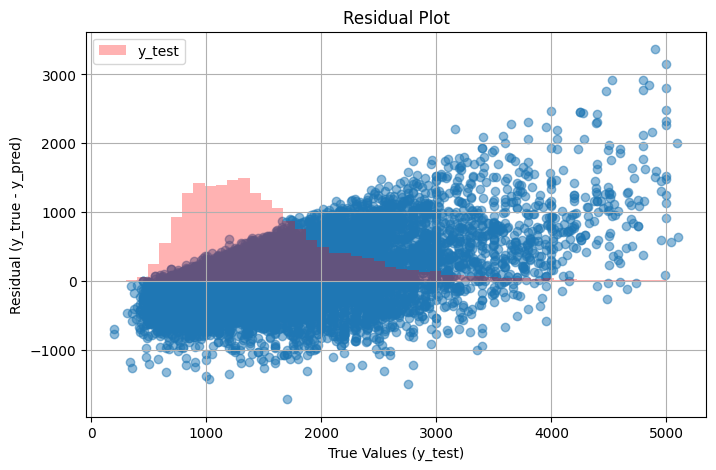

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import TargetEncoder

# ---------------------------------------------------------
# 1️⃣ Finales Alpha aus Nested CV (von dir vorher berechnet)
# ---------------------------------------------------------
best_parameters = ridge_poly_cv.get_best_params()   # liefert Liste von dicts

alpha_values = [float(list(p.values())[0]) for p in best_parameters]
final_alpha = np.median(alpha_values)
print("Final Alpha:", final_alpha)

# ---------------------------------------------------------
# 2️⃣ Train/Test Split
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# ---------------------------------------------------------
# 3️⃣ Target Encoding korrekt (nur auf TRAIN fitten!)
# ---------------------------------------------------------
te = TargetEncoder(cols=["state", "cityname"])   # deine kategorische Spalte

# Auf TRAIN fitten
te.fit(X_train[["state", "cityname"]], y_train)

# Transformieren
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

X_train_enc[["cityname", "state"]] = te.transform(X_train[["cityname", "state"]])
X_test_enc[["cityname", "state"]] = te.transform(X_test[["cityname", "state"]])

# 1. Alpha setzen
poly_ridge.set_params(ridge__alpha=final_alpha)

# 2. Fitten
poly_ridge.fit(X_train_enc, y_train)

# 3. Vorhersagen
y_pred = poly_ridge.predict(X_test_enc)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test R²:", r2)

# ---------------------------------------------------------
# 6️⃣ Residual Plot (Residuals oder Absolute Error)
# ---------------------------------------------------------
residuals = y_test - y_pred
abs_error = np.abs(y_test - y_pred)

plt.figure(figsize=(8,5))
scatter = plt.scatter(y_test, residuals, 
                      alpha=0.5)
plt.xlabel("True Values (y_test)")
plt.ylabel("Residual (y_true - y_pred)")
plt.title("Residual Plot")
plt.grid(True)
plt.hist(y_test, bins = 50, alpha=0.3, label='y_test', color='red')
plt.legend()
plt.show()